## Задача

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

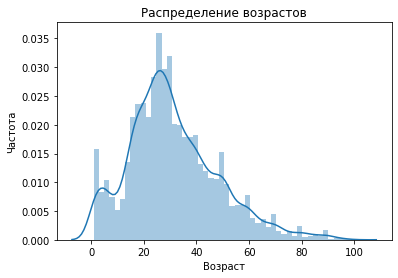

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
sns.distplot(labels['real_age'], bins=50)
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


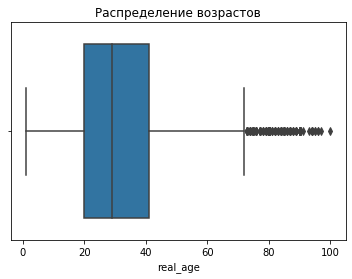

In [3]:
print(labels.real_age.describe())
plt.title('Распределение возрастов')
sns.boxplot(labels.real_age)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

features, target = next(train_datagen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(20,20))
for i in range(12):
    fig.add_subplot(10, 10, i+1)
    plt.imshow(features[i])
    plt.figsize
    plt.title(target[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25
                                       )
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=directory,
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            subset='training',
            class_mode='raw',
            seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    val_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=directory,
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            subset='validation',
            class_mode='raw',
            seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, batch_size=batch_size,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
              verbose=2, epochs=epochs)
    return model


```

```

Train for 178 steps, validate for 60 steps
Epoch 1/20
2020-12-04 17:20:07.365476: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-04 17:20:07.777148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 50s - loss: 197.7354 - mae: 10.3814 - val_loss: 615.7268 - val_mae: 19.8197
Epoch 2/20
178/178 - 40s - loss: 102.5994 - mae: 7.7053 - val_loss: 501.1697 - val_mae: 17.3094
Epoch 3/20
178/178 - 41s - loss: 62.5317 - mae: 6.0303 - val_loss: 467.5311 - val_mae: 16.4987
Epoch 4/20
178/178 - 40s - loss: 39.5569 - mae: 4.8530 - val_loss: 164.1401 - val_mae: 9.6752
Epoch 5/20
178/178 - 40s - loss: 27.1469 - mae: 4.0272 - val_loss: 147.9693 - val_mae: 9.3289
Epoch 6/20
178/178 - 40s - loss: 21.4569 - mae: 3.6028 - val_loss: 81.7385 - val_mae: 6.7854
Epoch 7/20
178/178 - 40s - loss: 16.9202 - mae: 3.1308 - val_loss: 90.0847 - val_mae: 7.3563
Epoch 8/20
178/178 - 40s - loss: 13.4380 - mae: 2.8147 - val_loss: 81.5071 - val_mae: 6.7830
Epoch 9/20
178/178 - 40s - loss: 12.0018 - mae: 2.6354 - val_loss: 81.4309 - val_mae: 6.8822
Epoch 10/20
178/178 - 40s - loss: 10.8122 - mae: 2.5104 - val_loss: 76.1718 - val_mae: 6.5813
Epoch 11/20
178/178 - 40s - loss: 10.0951 - mae: 2.4236 - val_loss: 90.3103 - val_mae: 7.3273
Epoch 12/20
178/178 - 40s - loss: 9.1135 - mae: 2.2998 - val_loss: 79.7821 - val_mae: 6.7988
Epoch 13/20
178/178 - 40s - loss: 8.3249 - mae: 2.2029 - val_loss: 72.7964 - val_mae: 6.4196
Epoch 14/20
178/178 - 40s - loss: 8.0377 - mae: 2.1606 - val_loss: 90.7658 - val_mae: 7.3588
Epoch 15/20
178/178 - 40s - loss: 8.5414 - mae: 2.2079 - val_loss: 83.0194 - val_mae: 6.7480
Epoch 16/20
178/178 - 40s - loss: 8.4480 - mae: 2.1924 - val_loss: 84.1616 - val_mae: 7.0156
Epoch 17/20
178/178 - 40s - loss: 8.6072 - mae: 2.2504 - val_loss: 78.2339 - val_mae: 6.6398
Epoch 18/20
178/178 - 40s - loss: 8.6166 - mae: 2.2459 - val_loss: 102.3626 - val_mae: 7.2808
Epoch 19/20
178/178 - 40s - loss: 9.2214 - mae: 2.2896 - val_loss: 88.3615 - val_mae: 7.3746
Epoch 20/20
178/178 - 40s - loss: 10.5019 - mae: 2.4843 - val_loss: 84.6153 - val_mae: 6.7207

```

# 3. Анализ обученной модели

1. В наборе данных мы имеем данные о возрастах людей и фотографии с их лицами. Распределение возрастов нормальное, скошенное вправо (положительно асимметричное). Показанное на графике положительно скошенное распределение имеет длинный хвост с правой стороны.

Коэффициент асимметрии распределения

In [17]:
print(labels.skew())

real_age    0.729609
dtype: float64


Интегральные (кумулятивные) функции распределения

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  import sys


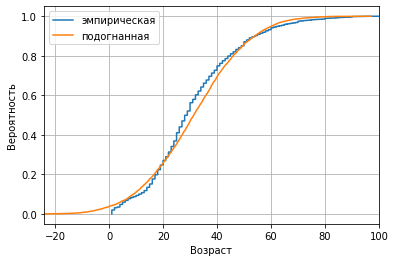

In [16]:
from scipy import stats
import scipy as sp

def empirical_cdf(x):
    """Вернуть эмпирическую функцию распределения для x"""
    sx  = sorted(x)
    return pd.DataFrame( {0: sx, 1:sp.arange(len(sx))/len(sx)} )

emp      = labels.real_age
fitted   = stats.norm.rvs(emp.mean(), emp.std(ddof=0), len(emp))
df  = empirical_cdf(emp)
df2 = empirical_cdf(fitted)
ax  = df.plot(0, 1, label='эмпирическая')    
df2.plot(0, 1, label='подогнанная', grid=True, ax=ax)    
plt.xlabel('Возраст')
plt.ylabel('Вероятность')
plt.legend(loc='best')             
plt.show()   

__Вывод__ : исходя из коэффициента ассиметрии (Ка > 0.5) можно сделать вывод, что ассиметрия значительна и в выборке представлено больше людей молодого возраста, о чем мы можем судить из графика распределения возрастов (п.1).

__2. Модель.
Для обучения и валидации модели мы поделили исходную выборку в пропорциях 3:1.__

Для обучения модели была использована структура нейронной сети ResNet50 с предобученными весами на датасете 'imagenet'.
Для обработки данных, полученных из модели  Resnet применен слой GlobalAveragePooling2D.
Выходным слоем является полносвязный слой с одним нейроном и функцией активации 'relu'.

Из полученных результатов обучения модели можно сделать вывод, что модель достигла требуемой точности уже на 6 эпохе, а дальше стала переобучаться.
Однако функция потерь продолжила уменьшаться ,что говорит о том, что на 6 эпохе веса были подобраны не оптимально.
Так как шаг градиента был взят достаточно малым, на 20 эпохе мы получили примерно то же значение MAE для тестовой выборки ,что и на 6ой, однако значение функции потерь уменьшилось в 2 раза.

## Вывод

Для выполнения первой поставленной задачи - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы - созданная нейронная сеть подходит, так как средняя ошибка в 6,7 лет довольно мала, если судить о предпочтениях в покупках.

Для проверки соотсветствия возраста для продажи алкоголя данный алгоритм может быть недостаточно точным. Однако можно проверять документы у всех людей по верхней границе ошибки, т.е. до 25 лет включительно, однако это может быть только дополнительным фактором для проверки.